Much of the programming work in data analysis and modeling is spent on data preparation:
loading, cleaning, transforming, and rearranging. Sometimes the way that data
is stored in files or databases is not the way you need it for a data processing application.
Many people choose to do ad hoc processing of data from one form to another using
a general purpose programming, like Python, Perl, R, or Java, or UNIX text processing
tools like sed or awk. Fortunately, pandas along with the Python standard library provide
you with a high-level, flexible, and high-performance set of core manipulations
and algorithms to enable you to wrangle data into the right form without much trouble.
If you identify a type of data manipulation that isn抰 anywhere in this book or elsewhere
in the pandas library, feel free to suggest it on the mailing list or GitHub site. Indeed,
much of the design and implementation of pandas has been driven by the needs of real
world applications.

Page 177 - Page 217

## Combining and Merging Data Sets

Data contained in pandas objects can be combined together in a number of built-in
ways:
• pandas.merge connects rows in DataFrames based on one or more keys. This will
be familiar to users of SQL or other relational databases, as it implements database
join operations.
• pandas.concat glues or stacks together objects along an axis.
• combine_first instance method enables splicing together overlapping data to fill
in missing values in one object with values from another.
I will address each of these and give a number of examples. They’ll be utilized in examples
throughout the rest of the book.

### Database-Style DataFrame Merges

Merge or join operations combine data sets by linking rows using one or more keys.
These operations are central to relational databases. The merge function in pandas is
the main entry point for using these algorithms on your data. Let's start with an example:

In [3]:
from pandas import Series, DataFrame
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df1 = DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                 'data1': range(7)})
df1

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,a
6,6,b


In [5]:
df2 = DataFrame({'key': ['a', 'b', 'd'],
                 'data2': range(3)})
df2

,data2,key
0,0,a
1,1,b
2,2,d


This is an example of a many-to-one merge situation; the data in df1 has multiple rows
labeled a and b, whereas df2 has only one row for each value in the key column. Calling
merge with these objects we obtain:

In [6]:
pd.merge(df1, df2)

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


Note that I didn’t specify which column to join on. If not specified, merge uses the
overlapping column names as the keys. It’s a good practice to specify explicitly, though:

In [7]:
pd.merge(df1, df2, on = 'key')

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


If the column names are different in each object, you can specify them separately:

In [8]:
df3 = DataFrame({'lkey':['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                'data1': range(7)})
df3

,data1,lkey
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,a
6,6,b


In [9]:
df4 = DataFrame({'rkey': ['a', 'b', 'd'],
    'data2': range(3)})
df4

,data2,rkey
0,0,a
1,1,b
2,2,d


In [10]:
pd.merge(df3, df4, left_on='lkey', right_on='rkey')

,data1,lkey,data2,rkey
0,0,b,1,b
1,1,b,1,b
2,6,b,1,b
3,2,a,0,a
4,4,a,0,a
5,5,a,0,a


You probably noticed that the 'c' and 'd' values and associated data are missing from
the result. By default merge does an 'inner' join; the keys in the result are the intersection.
Other possible options are 'left', 'right', and 'outer'. The outer join takes the
union of the keys, combining the effect of applying both left and right joins:

In [11]:
pd.merge(df1, df2, how='outer')

,data1,key,data2
0,0.0,b,1.0
1,1.0,b,1.0
2,6.0,b,1.0
3,2.0,a,0.0
4,4.0,a,0.0
5,5.0,a,0.0
6,3.0,c,NaN
7,NaN,d,2.0


Many-to-many merges have well-defined though not necessarily intuitive behavior.
Here’s an example:

In [12]:
df1 = DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'],
     'data1': range(6)})
df1

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,b


In [13]:
df2 = DataFrame({'key': ['a', 'b', 'a', 'b', 'd'],
     'data2': range(5)})
df2

,data2,key
0,0,a
1,1,b
2,2,a
3,3,b
4,4,d


In [14]:
# 'Left' Seems to mean that the sequence of the key values is in accordance to the left data's key sequence.
pd.merge(df1, df2, on='key', how='left')

,data1,key,data2
0,0,b,1.0
1,0,b,3.0
2,1,b,1.0
3,1,b,3.0
4,2,a,0.0
5,2,a,2.0
6,3,c,NaN
7,4,a,0.0
8,4,a,2.0
9,5,b,1.0


Many-to-many joins form the Cartesian product of the rows. Since there were 3 'b'
rows in the left DataFrame and 2 in the right one, there are 6 'b' rows in the result.
The join method only affects the distinct key values appearing in the result:

In [15]:
pd.merge(df1, df2, how = 'inner')

,data1,key,data2
0,0,b,1
1,0,b,3
2,1,b,1
3,1,b,3
4,5,b,1
5,5,b,3
6,2,a,0
7,2,a,2
8,4,a,0
9,4,a,2


To merge with multiple keys, pass a list of column names:

In [16]:
left = DataFrame({'key1': ['foo', 'foo', 'bar'],
                    'key2': ['one', 'two', 'one'],
                    'lval': [1, 2, 3]})
left

,key1,key2,lval
0,foo,one,1
1,foo,two,2
2,bar,one,3


In [17]:
right = DataFrame({'key1': ['foo', 'foo', 'bar', 'bar'],
                    'key2': ['one', 'one', 'one', 'two'],
                    'rval': [4, 5, 6, 7]})
right

,key1,key2,rval
0,foo,one,4
1,foo,one,5
2,bar,one,6
3,bar,two,7


In [18]:
pd.merge(left, right, on=['key1', 'key2'], how='outer')

,key1,key2,lval,rval
0,foo,one,1.0,4.0
1,foo,one,1.0,5.0
2,foo,two,2.0,NaN
3,bar,one,3.0,6.0
4,bar,two,NaN,7.0


To determine which key combinations will appear in the result depending on the choice
of merge method, think of the multiple keys as forming an array of tuples to be used
as a single join key (even though it’s not actually implemented that way).

When joining columns-on-columns, the indexes on the passed Data-
Frame objects are discarded.

A last issue to consider in merge operations is the treatment of overlapping column
names. While you can address the overlap manually (see the later section on renaming
axis labels), merge has a suffixes option for specifying strings to append to overlapping
names in the left and right DataFrame objects:

In [19]:
pd.merge(left, right, on='key1')

,key1,key2_x,lval,key2_y,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


See Table 7-1 for an argument reference on merge. Joining on index is the subject of the
next section.

Table 7-1. merge function arguments

Argument Description

left: DataFrame to be merged on the left side

right: DataFrame to be merged on the right side

how: One of 'inner', 'outer', 'left' or 'right'. 'inner' by default

on: Column names to join on. Must be found in both DataFrame objects. If not specified and no other join keys
given, will use the intersection of the column names in left and right as the join keys

left_on: Columns in left DataFrame to use as join keys

right_on: Analogous to left_on for left DataFrame

left_index: Use row index in left as its join key (or keys, if a MultiIndex)

right_index: Analogous to left_index

sort: Sort merged data lexicographically by join keys; True by default. Disable to get better performance in some
cases on large datasets

suffixes: Tuple of string values to append to column names in case of overlap; defaults to ('_x', '_y'). For
example, if 'data' in both DataFrame objects, would appear as 'data_x' and 'data_y' in result

copy: If False, avoid copying data into resulting data structure in some exceptional cases. By default always copies

### Merging on Index

In some cases, the merge key or keys in a DataFrame will be found in its index. In this
case, you can pass left_index=True or right_index=True (or both) to indicate that the
index should be used as the merge key:

In [20]:
left1 = DataFrame({'key': ['a', 'b', 'a', 'a', 'b', 'c'],
    'value': range(6)})
left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [21]:
right1 = DataFrame({'group_val': [3.5, 7]}, index=['a', 'b'])
right1

,group_val
a,3.5
b,7.0


In [22]:
# Indicate we should use the right index as the one to merge
pd.merge(left1, right1, left_on='key', right_index=True)

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0


Since the default merge method is to intersect the join keys, you can instead form the
union of them with an outer join:

In [23]:
pd.merge(left1, right1, left_on='key', right_index=True, how='outer')

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


With hierarchically-indexed data, things are a bit more complicated:

In [24]:
lefth = DataFrame({'key1': ['Ohio', 'Ohio', 'Ohio', 'Nevada', 'Nevada'],
....: 'key2': [2000, 2001, 2002, 2001, 2002],
....: 'data': np.arange(5.)})
lefth

,data,key1,key2
0,0.0,Ohio,2000
1,1.0,Ohio,2001
2,2.0,Ohio,2002
3,3.0,Nevada,2001
4,4.0,Nevada,2002


In [25]:
righth = DataFrame(np.arange(12).reshape((6, 2)),
....: index=[['Nevada', 'Nevada', 'Ohio', 'Ohio', 'Ohio', 'Ohio'],
....: [2001, 2000, 2000, 2000, 2001, 2002]],
....: columns=['event1', 'event2'])
righth

event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

In this case, you have to indicate multiple columns to merge on as a list (pay attention
to the handling of duplicate index values):

In [26]:
pd.merge(lefth, righth, left_on=['key1', 'key2'], right_index=True)

,data,key1,key2,event1,event2
0,0.0,Ohio,2000,4,5
0,0.0,Ohio,2000,6,7
1,1.0,Ohio,2001,8,9
2,2.0,Ohio,2002,10,11
3,3.0,Nevada,2001,0,1


In [27]:
pd.merge(lefth, righth, left_on=['key1', 'key2'],
....: right_index=True, how='outer')

,data,key1,key2,event1,event2
0,0.0,Ohio,2000,4.0,5.0
0,0.0,Ohio,2000,6.0,7.0
1,1.0,Ohio,2001,8.0,9.0
2,2.0,Ohio,2002,10.0,11.0
3,3.0,Nevada,2001,0.0,1.0
4,4.0,Nevada,2002,NaN,NaN
4,NaN,Nevada,2000,2.0,3.0


Using the indexes of both sides of the merge is also not an issue:

In [28]:
left2 = DataFrame([[1., 2.], [3., 4.], [5., 6.]], index=['a', 'c', 'e'],
....: columns=['Ohio', 'Nevada'])

left2

,Ohio,Nevada
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [29]:
right2 = DataFrame([[7., 8.], [9., 10.], [11., 12.], [13, 14]],
....: index=['b', 'c', 'd', 'e'], columns=['Missouri', 'Alabama'])

right2

,Missouri,Alabama
b,7.0,8.0
c,9.0,10.0
d,11.0,12.0
e,13.0,14.0


In [30]:
pd.merge(left2, right2, how = 'outer', left_index = True, right_index = True)

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


DataFrame has a more convenient join instance for merging by index. It can also be
used to combine together many DataFrame objects having the same or similar indexes
but non-overlapping columns. In the prior example, we could have written:

In [31]:
left2.join(right2, how='outer')

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


In [32]:
# The difference from last cell is only the sequences shown as the first or second column 
right2.join(left2, how = 'outer')

,Missouri,Alabama,Ohio,Nevada
a,NaN,NaN,1.0,2.0
b,7.0,8.0,NaN,NaN
c,9.0,10.0,3.0,4.0
d,11.0,12.0,NaN,NaN
e,13.0,14.0,5.0,6.0


In part for legacy reasons (much earlier versions of pandas), DataFrame’s join method
performs a left join on the join keys. It also supports joining the index of the passed
DataFrame on one of the columns of the calling DataFrame:

In [33]:
left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [34]:
right1

,group_val
a,3.5
b,7.0


In [35]:
left1.join(right1, on='key')

,key,value,group_val
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0
5,c,5,NaN


Lastly, for simple index-on-index merges, you can pass a list of DataFrames to join as
an alternative to using the more general concat function described below:

In [36]:
another = DataFrame([[7., 8.], [9., 10.], [11., 12.], [16., 17.]],
....: index=['a', 'c', 'e', 'f'], columns=['New York', 'Oregon'])
another

,New York,Oregon
a,7.0,8.0
c,9.0,10.0
e,11.0,12.0
f,16.0,17.0


In [37]:
left2

,Ohio,Nevada
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [38]:
another

,New York,Oregon
a,7.0,8.0
c,9.0,10.0
e,11.0,12.0
f,16.0,17.0


In [39]:
# Join function can be used to merge more than two columns of data, as shown here.
left2.join([right2, another])

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0


### Concatenating Along on Axis

Another kind of data combination operation is alternatively referred to as concatenation,
binding, or stacking. NumPy has a concatenate function for doing this with raw
NumPy arrays:

In [40]:
arr = np.arange(12).reshape((3, 4))
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [41]:
np.concatenate([arr, arr], axis = 1)

array([[ 0,  1,  2,  3,  0,  1,  2,  3],
       [ 4,  5,  6,  7,  4,  5,  6,  7],
       [ 8,  9, 10, 11,  8,  9, 10, 11]])

In the context of pandas objects such as Series and DataFrame, having labeled axes
enable you to further generalize array concatenation. In particular, you have a number
of additional things to think about:

• If the objects are indexed differently on the other axes, should the collection of
axes be unioned or intersected?

• Do the groups need to be identifiable in the resulting object?

• Does the concatenation axis matter at all?

The concat function in pandas provides a consistent way to address each of these concerns.
I’ll give a number of examples to illustrate how it works. Suppose we have three
Series with no index overlap:

In [42]:
s1 = Series([0, 1], index=['a', 'b'])
s1

a    0
b    1
dtype: int64

In [43]:
s2 = Series([2, 3, 4], index=['c', 'd', 'e'])
s2

c    2
d    3
e    4
dtype: int64

In [44]:
s3 = Series([5, 6], index=['f', 'g'])
s3

f    5
g    6
dtype: int64

Calling concat with these object in a list glues together the values and indexes:

In [45]:
pd.concat([s1, s2, s3])

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

By default concat works along axis=0, producing another Series. If you pass axis=1, the
result will instead be a DataFrame (axis=1 is the columns):

In [46]:
# Made it a matrix, the number of columns depends on the number of series.
pd.concat([s1, s2, s3], axis=1)

,0,1,2
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


In this case there is no overlap on the other axis, which as you can see is the sorted
union (the 'outer' join) of the indexes. You can instead intersect them by passing
join='inner':

In [47]:
s4 = pd.concat([s1 * 5, s3])
s4

a    0
b    5
f    5
g    6
dtype: int64

In [48]:
s1

a    0
b    1
dtype: int64

In [49]:
pd.concat([s1, s4], axis=1)

,0,1
a,0.0,0
b,1.0,5
f,NaN,5
g,NaN,6


In [50]:
pd.concat([s1, s4], axis=1, join='inner')

,0,1
a,0,0
b,1,5


You can even specify the axes to be used on the other axes with join_axes:

In [51]:
pd.concat([s1, s4], axis=1, join_axes=[['a', 'c', 'b', 'e']])

,0,1
a,0.0,0.0
c,NaN,NaN
b,1.0,5.0
e,NaN,NaN


One issue is that the concatenated pieces are not identifiable in the result. Suppose
instead you wanted to create a hierarchical index on the concatenation axis. To do this,
use the keys argument:

In [52]:
result = pd.concat([s1, s1, s3], keys=['one', 'two', 'three'])
result

one    a    0
       b    1
two    a    0
       b    1
three  f    5
       g    6
dtype: int64

In [53]:
# Much more on the unstack function later, more like making it a pivot table
result.unstack()

,a,b,f,g
one,0.0,1.0,NaN,NaN
two,0.0,1.0,NaN,NaN
three,NaN,NaN,5.0,6.0


In the case of combining Series along axis=1, the keys become the DataFrame column
headers:

In [54]:
pd.concat([s1, s2, s3], axis=1, keys=['one', 'two', 'three'])

,one,two,three
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


The same logic extends to DataFrame objects:

In [55]:
df1 = DataFrame(np.arange(6).reshape(3, 2), index=['a', 'b', 'c'],
....: columns=['one', 'two'])
df1

,one,two
a,0,1
b,2,3
c,4,5


In [56]:
df2 = DataFrame(5 + np.arange(4).reshape(2, 2), index=['a', 'c'],
....: columns=['three', 'four'])
df2

,three,four
a,5,6
c,7,8


In [57]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'])

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

If you pass a dict of objects instead of a list, the dict’s keys will be used for the keys
option:

In [58]:
pd.concat({'level1': df1, 'level2': df2}, axis=1)

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

There are a couple of additional arguments governing how the hierarchical index is
created (see Table 7-2):

In [59]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'],
....: names=['upper', 'lower'])

upper level1     level2     
lower    one two  three four
a          0   1    5.0  6.0
b          2   3    NaN  NaN
c          4   5    7.0  8.0

A last consideration concerns DataFrames in which the row index is not meaningful in
the context of the analysis:

In [60]:
df1 = DataFrame(np.random.randn(3, 4), columns = ['a', 'b', 'c', 'd'])
df1

,a,b,c,d
0,0.416384,-0.166046,1.067415,-0.222097
1,0.857254,0.792057,-0.442960,1.116195
2,-0.149849,1.190296,0.156434,-0.792644


In [61]:
df2 = DataFrame(np.random.randn(2, 3), columns=['b', 'd', 'a'])
df2

,b,d,a
0,-1.410296,1.704910,0.139943
1,-1.330008,1.115965,0.479769


In this case, you can pass ignore_index=True:

In [62]:
pd.concat([df1, df2], ignore_index = True)

,a,b,c,d
0,0.416384,-0.166046,1.067415,-0.222097
1,0.857254,0.792057,-0.442960,1.116195
2,-0.149849,1.190296,0.156434,-0.792644
3,0.139943,-1.410296,NaN,1.704910
4,0.479769,-1.330008,NaN,1.115965


Table 7-2. concat function arguments

Argument     Description

objs: List or dict of pandas objects to be concatenated. The only required argument

axis: Axis to concatenate along; defaults to 0

join: One of 'inner', 'outer', defaulting to 'outer'; whether to intersection (inner) or union
(outer) together indexes along the other axes

join_axes: Specific indexes to use for the other n-1 axes instead of performing union/intersection logic

keys: Values to associate with objects being concatenated, forming a hierarchical index along the
concatenation axis. Can either be a list or array of arbitrary values, an array of tuples, or a list of
arrays (if multiple level arrays passed in levels)

levels: Specific indexes to use as hierarchical index level or levels if keys passed

names: Names for created hierarchical levels if keys and / or levels passed

verify_integrity: Check new axis in concatenated object for duplicates and raise exception if so. By default
(False) allows duplicates

ignore_index: Do not preserve indexes along concatenation axis, instead producing a new
range(total_length) index

### Combining Data with Overlap

Another data combination situation can’t be expressed as either a merge or concatenation
operation. You may have two datasets whose indexes overlap in full or part. As
a motivating example, consider NumPy’s where function, which expressed a vectorized
if-else:

In [63]:
a = Series([np.nan, 2.5, np.nan, 3.5, 4.5, np.nan],
....: index=['f', 'e', 'd', 'c', 'b', 'a'])
a

f    NaN
e    2.5
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

In [64]:
b = Series(np.arange(len(a), dtype=np.float64),
....: index=['f', 'e', 'd', 'c', 'b', 'a'])
b

f    0.0
e    1.0
d    2.0
c    3.0
b    4.0
a    5.0
dtype: float64

In [65]:
b[-1] = np.nan

In [66]:
b

f    0.0
e    1.0
d    2.0
c    3.0
b    4.0
a    NaN
dtype: float64

Series has a combine_first method, which performs the equivalent of this operation
plus data alignment:

In [67]:
b[:-2]

f    0.0
e    1.0
d    2.0
c    3.0
dtype: float64

In [68]:
a[2:]

d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

In [69]:
b[:-2].combine_first(a[2:])

a    NaN
b    4.5
c    3.0
d    2.0
e    1.0
f    0.0
dtype: float64

With DataFrames, combine_first naturally does the same thing column by column, so
you can think of it as “patching” missing data in the calling object with data from the
object you pass:

In [70]:
df1 = DataFrame({'a': [1., np.nan, 5., np.nan],
....: 'b': [np.nan, 2., np.nan, 6.],
....: 'c': range(2, 18, 4)})
df1

,a,b,c
0,1.0,NaN,2
1,NaN,2.0,6
2,5.0,NaN,10
3,NaN,6.0,14


In [71]:
df2 = DataFrame({'a': [5., 4., np.nan, 3., 7.],
....: 'b': [np.nan, 3., 4., 6., 8.]})
df2

,a,b
0,5.0,NaN
1,4.0,3.0
2,NaN,4.0
3,3.0,6.0
4,7.0,8.0


In [72]:
df1.combine_first(df2)

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN


## Reshaping and Pivoting

There are a number of fundamental operations for rearranging tabular data. These are
alternatingly referred to as reshape or pivot operations.

### Reshaping with Hierarchical Indexing

Hierarchical indexing provides a consistent way to rearrange data in a DataFrame.
There are two primary actions:
    
• stack: this “rotates” or pivots from the columns in the data to the rows
    
• unstack: this pivots from the rows into the columns

I’ll illustrate these operations through a series of examples. Consider a small DataFrame
with string arrays as row and column indexes:

In [73]:
data = DataFrame(np.arange(6).reshape((2,3)), 
                index = pd.Index(['Ohio', 'Colorado'], name = 'state'), 
                columns = pd.Index(['one', 'two', 'three'], name = 'number'))
data

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


Using the stack method on this data pivots the columns into the rows, producing a
Series:

In [74]:
result = data.stack()
result

state     number
Ohio      one       0
          two       1
          three     2
Colorado  one       3
          two       4
          three     5
dtype: int32

From a hierarchically-indexed Series, you can rearrange the data back into a DataFrame
with unstack:

In [75]:
result.unstack()

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


By default the innermost level is unstacked (same with stack). You can unstack a different
level by passing a level number or name:

In [76]:
result.unstack(0)

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


In [77]:
result.unstack(1)

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


In [78]:
# See the difference between putting in 0 and 1
result.unstack(0)

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


In [79]:
result.unstack('state')

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


Unstacking might introduce missing data if all of the values in the level aren’t found in
each of the subgroups:

In [80]:
s1 = Series([0, 1, 2, 3], index=['a', 'b', 'c', 'd'])
s1

a    0
b    1
c    2
d    3
dtype: int64

In [81]:
s2 = Series([4, 5, 6], index=['c', 'd', 'e'])
s2

c    4
d    5
e    6
dtype: int64

In [82]:
data2 = pd.concat([s1, s2], keys=['one', 'two'])
data2

one  a    0
     b    1
     c    2
     d    3
two  c    4
     d    5
     e    6
dtype: int64

In [83]:
data2.unstack()

,a,b,c,d,e
one,0.0,1.0,2.0,3.0,NaN
two,NaN,NaN,4.0,5.0,6.0


Stacking filters out missing data by default, so the operation is easily invertible:

In [84]:
data2.unstack().stack()

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
two  c    4.0
     d    5.0
     e    6.0
dtype: float64

In [85]:
data2.unstack().stack(dropna=False)

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
     e    NaN
two  a    NaN
     b    NaN
     c    4.0
     d    5.0
     e    6.0
dtype: float64

When unstacking in a DataFrame, the level unstacked becomes the lowest level in the
result:

In [86]:
df = DataFrame({'left': result, 'right': result + 5},
.....: columns=pd.Index(['left', 'right'], name='side'))
df

side             left  right
state    number             
Ohio     one        0      5
         two        1      6
         three      2      7
Colorado one        3      8
         two        4      9
         three      5     10

In [87]:
df.unstack('state')

side   left          right         
state  Ohio Colorado  Ohio Colorado
number                             
one       0        3     5        8
two       1        4     6        9
three     2        5     7       10

In [88]:
df.unstack('state').stack('side')

state         Ohio  Colorado
number side                 
one    left      0         3
       right     5         8
two    left      1         4
       right     6         9
three  left      2         5
       right     7        10

### Pivoting "long' to "wide" Format

A common way to store multiple time series in databases and CSV is in so-called long
or stacked format:

In [89]:
In [116]: ldata[:10]
Out[116]:
date item value
0 1959-03-31 00:00:00 realgdp 2710.349
1 1959-03-31 00:00:00 infl 0.000
2 1959-03-31 00:00:00 unemp 5.800
3 1959-06-30 00:00:00 realgdp 2778.801
4 1959-06-30 00:00:00 infl 2.340
5 1959-06-30 00:00:00 unemp 5.100
6 1959-09-30 00:00:00 realgdp 2775.488
7 1959-09-30 00:00:00 infl 2.740
8 1959-09-30 00:00:00 unemp 5.300
9 1959-12-31 00:00:00 realgdp 2785.204

SyntaxError: invalid syntax (<ipython-input-89-6db0f3449c91>, line 2)

Data is frequently stored this way in relational databases like MySQL as a fixed schema
(column names and data types) allows the number of distinct values in the item column
to increase or decrease as data is added or deleted in the table. In the above example
date and item would usually be the primary keys (in relational database parlance),
offering both relational integrity and easier joins and programmatic queries in many
cases. The downside, of course, is that the data may not be easy to work with in long
format; you might prefer to have a DataFrame containing one column per distinct
item value indexed by timestamps in the date column. DataFrame’s pivot method performs
exactly this transformation:

In [90]:
# Try something already in th conda root, but different from the ldata file from the textbook, which can't be found though.
data = pd.read_csv('macrodata.csv')
data.head(10)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19
5,1960.0,2.0,2834.390,1792.9,298.152,460.400,1966.1,29.55,140.2,2.68,5.2,180.671,0.14,2.55
6,1960.0,3.0,2839.022,1785.8,296.375,474.676,1967.8,29.75,140.9,2.36,5.6,181.528,2.70,-0.34
7,1960.0,4.0,2802.616,1788.2,259.764,476.434,1966.6,29.84,141.1,2.29,6.3,182.287,1.21,1.08
8,1961.0,1.0,2819.264,1787.7,266.405,475.854,1984.5,29.81,142.1,2.37,6.8,182.992,-0.40,2.77
9,1961.0,2.0,2872.005,1814.3,286.246,480.328,2014.4,29.92,142.9,2.29,7.0,183.691,1.47,0.81


In [91]:
# Figure out how to select several separated columns in a dataframe.
ldata = data.ix[:, ['year', 'quarter', 'realgdp', 'infl', 'unemp']]
ldata

,year,quarter,realgdp,infl,unemp
0,1959.0,1.0,2710.349,0.00,5.8
1,1959.0,2.0,2778.801,2.34,5.1
2,1959.0,3.0,2775.488,2.74,5.3
3,1959.0,4.0,2785.204,0.27,5.6
4,1960.0,1.0,2847.699,2.31,5.2
5,1960.0,2.0,2834.390,0.14,5.2
6,1960.0,3.0,2839.022,2.70,5.6
7,1960.0,4.0,2802.616,1.21,6.3
8,1961.0,1.0,2819.264,-0.40,6.8
9,1961.0,2.0,2872.005,1.47,7.0


In [92]:
# Keep tring based on the textbook, although different from the textbook, content understood.
# This shows the table for the realgdp alone
pivoted = ldata.pivot('year','quarter', 'realgdp')
pivoted

quarter,1.0,2.0,3.0,4.0
year,,,,
1959.0,2710.349,2778.801,2775.488,2785.204
1960.0,2847.699,2834.390,2839.022,2802.616
1961.0,2819.264,2872.005,2918.419,2977.830
1962.0,3031.241,3064.709,3093.047,3100.563
1963.0,3141.087,3180.447,3240.332,3264.967
1964.0,3338.246,3376.587,3422.469,3431.957
1965.0,3516.251,3563.960,3636.285,3724.014
1966.0,3815.423,3828.124,3853.301,3884.520
1967.0,3918.740,3919.556,3950.826,3980.970


The first two values passed are the columns to be used as the row and column index,
and finally an optional value column to fill the DataFrame. Suppose you had two value
columns that you wanted to reshape simultaneously:

In [93]:
ldata['value2'] = np.random.randn(len(ldata))
ldata[:5]

,year,quarter,realgdp,infl,unemp,value2
0,1959.0,1.0,2710.349,0.00,5.8,0.015625
1,1959.0,2.0,2778.801,2.34,5.1,-0.134817
2,1959.0,3.0,2775.488,2.74,5.3,-0.457157
3,1959.0,4.0,2785.204,0.27,5.6,0.713366
4,1960.0,1.0,2847.699,2.31,5.2,-0.385644


By omitting the last argument, you obtain a DataFrame with hierarchical columns:

In [94]:
pivoted = ldata.pivot('year', 'quarter')
pivoted.head(10)

realgdp                                infl                   unemp  \
quarter       1.0       2.0       3.0       4.0   1.0   2.0   3.0   4.0   1.0   
year                                                                            
1959.0   2710.349  2778.801  2775.488  2785.204  0.00  2.34  2.74  0.27   5.8   
1960.0   2847.699  2834.390  2839.022  2802.616  2.31  0.14  2.70  1.21   5.2   
1961.0   2819.264  2872.005  2918.419  2977.830 -0.40  1.47  0.80  0.80   6.8   
1962.0   3031.241  3064.709  3093.047  3100.563  2.26  0.13  2.11  0.79   5.6   
1963.0   3141.087  3180.447  3240.332  3264.967  0.53  2.75  0.78  2.46   5.8   
1964.0   3338.246  3376.587  3422.469  3431.957  0.13  0.90  1.29  2.05   5.5   
1965.0   3516.251  3563.960  3636.285  3724.014  1.28  2.54  0.89  2.90   4.9   
1966.0   3815.423  3828.124  3853.301  3884.520  4.99  2.10  4.90  0.61   3.9   
1967.0   3918.740  3919.556  3950.826  3980.970  2.42  3.61  3.58  4.72   3.8   
1968.0   4063.013  4131.998  4160.267  4178.293  3.50  5.77  4.56  4.51   3.7   

                          value2                                
quarter  2.0  3.0  4.0       1.0       2.0       3.0       4.0  
year                                                            
1959.0   5.1  5.3  5.6  0.015625 -0.134817 -0.457157  0.713366  
1960.0   5.2  5.6  6.3 -0.385644  0.454835 -0.202737 -0.128601  
1961.0   7.0  6.8  6.2  0.235670 -0.267026  0.622098  2.875608  
1962.0   5.5  5.6  5.5  0.415554  0.027709 -0.795054  0.354911  
1963.0   5.7  5.5  5.6 -0.199861  0.329183  1.401914 -0.499961  
1964.0   5.2  5.0  5.0  0.475731 -0.549709 -0.330928  0.605094  
1965.0   4.7  4.4  4.1 -1.376804 -0.201663  0.749077  0.378519  
1966.0   3.8  3.8  3.7  1.543294 -0.173255  0.095355 -0.006506  
1967.0   3.8  3.8  3.9 -1.141808 -0.048597 -0.537757 -2.335195  
1968.0   3.5  3.5  3.4 -0.487506 -2.784027  0.019983 -0.179740

Note that pivot is just a shortcut for creating a hierarchical index using set_index and
reshaping with unstack:

In [95]:
unstacked = ldata.set_index(['year', 'quarter']).unstack('quarter')
unstacked.head(10)

realgdp                                infl                   unemp  \
quarter       1.0       2.0       3.0       4.0   1.0   2.0   3.0   4.0   1.0   
year                                                                            
1959.0   2710.349  2778.801  2775.488  2785.204  0.00  2.34  2.74  0.27   5.8   
1960.0   2847.699  2834.390  2839.022  2802.616  2.31  0.14  2.70  1.21   5.2   
1961.0   2819.264  2872.005  2918.419  2977.830 -0.40  1.47  0.80  0.80   6.8   
1962.0   3031.241  3064.709  3093.047  3100.563  2.26  0.13  2.11  0.79   5.6   
1963.0   3141.087  3180.447  3240.332  3264.967  0.53  2.75  0.78  2.46   5.8   
1964.0   3338.246  3376.587  3422.469  3431.957  0.13  0.90  1.29  2.05   5.5   
1965.0   3516.251  3563.960  3636.285  3724.014  1.28  2.54  0.89  2.90   4.9   
1966.0   3815.423  3828.124  3853.301  3884.520  4.99  2.10  4.90  0.61   3.9   
1967.0   3918.740  3919.556  3950.826  3980.970  2.42  3.61  3.58  4.72   3.8   
1968.0   4063.013  4131.998  4160.267  4178.293  3.50  5.77  4.56  4.51   3.7   

                          value2                                
quarter  2.0  3.0  4.0       1.0       2.0       3.0       4.0  
year                                                            
1959.0   5.1  5.3  5.6  0.015625 -0.134817 -0.457157  0.713366  
1960.0   5.2  5.6  6.3 -0.385644  0.454835 -0.202737 -0.128601  
1961.0   7.0  6.8  6.2  0.235670 -0.267026  0.622098  2.875608  
1962.0   5.5  5.6  5.5  0.415554  0.027709 -0.795054  0.354911  
1963.0   5.7  5.5  5.6 -0.199861  0.329183  1.401914 -0.499961  
1964.0   5.2  5.0  5.0  0.475731 -0.549709 -0.330928  0.605094  
1965.0   4.7  4.4  4.1 -1.376804 -0.201663  0.749077  0.378519  
1966.0   3.8  3.8  3.7  1.543294 -0.173255  0.095355 -0.006506  
1967.0   3.8  3.8  3.9 -1.141808 -0.048597 -0.537757 -2.335195  
1968.0   3.5  3.5  3.4 -0.487506 -2.784027  0.019983 -0.179740

## Data Transformation

So far in this chapter we’ve been concerned with rearranging data. Filtering, cleaning,
and other tranformations are another class of important operations.

### Removing Duplicates

Duplicate rows may be found in a DataFrame for any number of reasons. Here is an
example:

In [96]:
data = DataFrame({'k1': ['one'] * 3 + ['two'] * 4,
.....: 'k2': [1, 1, 2, 3, 3, 4, 4]})
data

,k1,k2
0,one,1
1,one,1
2,one,2
3,two,3
4,two,3
5,two,4
6,two,4


The DataFrame method duplicated returns a boolean Series indicating whether each
row is a duplicate or not:

In [97]:
data.duplicated()

0    False
1     True
2    False
3    False
4     True
5    False
6     True
dtype: bool

Relatedly, drop_duplicates returns a DataFrame where the duplicated array is True:

In [98]:
data.drop_duplicates()

,k1,k2
0,one,1
2,one,2
3,two,3
5,two,4


Both of these methods by default consider all of the columns; alternatively you can
specify any subset of them to detect duplicates. Suppose we had an additional column
of values and wanted to filter duplicates only based on the 'k1' column:

In [99]:
data['v1'] = range(7)

In [100]:
data

,k1,k2,v1
0,one,1,0
1,one,1,1
2,one,2,2
3,two,3,3
4,two,3,4
5,two,4,5
6,two,4,6


In [101]:
data.drop_duplicates(['k1'])

,k1,k2,v1
0,one,1,0
3,two,3,3


duplicated and drop_duplicates by default keep the first observed value combination.
Passing take_last=True will return the last one:

In [102]:
data.drop_duplicates(['k1', 'k2'], take_last = True)

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: the take_last=True keyword is deprecated, use keep='last' instead
  if __name__ == '__main__':


,k1,k2,v1
1,one,1,1
2,one,2,2
4,two,3,4
6,two,4,6


### Transforming Data Using a Function or Mapping

For many data sets, you may wish to perform some transformation based on the values
in an array, Series, or column in a DataFrame. Consider the following hypothetical data
collected about some kinds of meat:

In [103]:
data = DataFrame({'food': ['bacon', 'pulled pork', 'bacon', 'Pastrami', 
                          'corned beef', 'Bacon', 'pastrami', 'honey ham',
                          'nova lox'],
                 'ounces': [4, 3, 12, 6, 7.5, 8, 3, 5, 6]})
data

,food,ounces
0,bacon,4.0
1,pulled pork,3.0
2,bacon,12.0
3,Pastrami,6.0
4,corned beef,7.5
5,Bacon,8.0
6,pastrami,3.0
7,honey ham,5.0
8,nova lox,6.0


Suppose you wanted to add a column indicating the type of animal that each food came
from. Let’s write down a mapping of each distinct meat type to the kind of animal:

In [104]:
meat_to_animal = {
'bacon': 'pig',
'pulled pork': 'pig',
'pastrami': 'cow',
'corned beef': 'cow',
'honey ham': 'pig',
'nova lox': 'salmon'
}

In [105]:
data['animal'] = data['food'].map(meat_to_animal)
data

,food,ounces,animal
0,bacon,4.0,pig
1,pulled pork,3.0,pig
2,bacon,12.0,pig
3,Pastrami,6.0,NaN
4,corned beef,7.5,cow
5,Bacon,8.0,NaN
6,pastrami,3.0,cow
7,honey ham,5.0,pig
8,nova lox,6.0,salmon


The map method on a Series accepts a function or dict-like object containing a mapping,
but as you can see above, here we have a small problem in that some of the meats above are capitalized and
others are not. Thus, we also need to convert each value to lower case:

In [106]:
# Very useful skill: convert to lower case in the cells in order to be mapped
# For simplying converting to another lower/higher case, just use:
# data.map(str.upper)
data['animal'] = data['food'].map(str.lower).map(meat_to_animal)
data

,food,ounces,animal
0,bacon,4.0,pig
1,pulled pork,3.0,pig
2,bacon,12.0,pig
3,Pastrami,6.0,cow
4,corned beef,7.5,cow
5,Bacon,8.0,pig
6,pastrami,3.0,cow
7,honey ham,5.0,pig
8,nova lox,6.0,salmon


We could also have passed a function that does all the work:

In [107]:
data['food'].map(lambda x: meat_to_animal[x.lower()])

0       pig
1       pig
2       pig
3       cow
4       cow
5       pig
6       cow
7       pig
8    salmon
Name: food, dtype: object

Using map is a convenient way to perform element-wise transformations and other data
cleaning-related operations.

### Replacing Values

Filling in missing data with the fillna method can be thought of as a special case of
more general value replacement. While map, as you’ve seen above, can be used to modify
a subset of values in an object, replace provides a simpler and more flexible way to do
so. Let’s consider this Series:

In [108]:
data = Series([1., -999., 2., -999., -1000., 3.])
data

0       1.0
1    -999.0
2       2.0
3    -999.0
4   -1000.0
5       3.0
dtype: float64

The -999 values might be sentinel values for missing data. To replace these with NA
values that pandas understands, we can use replace, producing a new Series:

In [109]:
data.replace(-999, np.nan)

0       1.0
1       NaN
2       2.0
3       NaN
4   -1000.0
5       3.0
dtype: float64

If you want to replace multiple values at once, you instead pass a list then the substitute
value:

In [110]:
data.replace([-999, -1000], np.nan)

0    1.0
1    NaN
2    2.0
3    NaN
4    NaN
5    3.0
dtype: float64

To use a different replacement for each value, pass a list of substitutes:

In [111]:
data.replace([-999, -1000], [np.nan, 0])

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

The argument passed can also be a dict:

In [112]:
data.replace({-999: np.nan, -1000:0})

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

### Renaming Axis Indexes

Like values in a Series, axis labels can be similarly transformed by a function or mapping
of some form to produce new, differently labeled objects. The axes can also be modified
in place without creating a new data structure. Here’s a simple example:

In [113]:
data = DataFrame(np.arange(12).reshape((3, 4)),
.....: index=['Ohio', 'Colorado', 'New York'],
.....: columns=['one', 'two', 'three', 'four'])
data

,one,two,three,four
Ohio,0,1,2,3
Colorado,4,5,6,7
New York,8,9,10,11


Like a Series, the axis indexes have a map method:

In [114]:
data.index = data.index.map(str.upper)

In [115]:
data

,one,two,three,four
OHIO,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


If you want to create a transformed version of a data set without modifying the original,
a useful method is rename:

In [116]:
data.rename(index=str.title, columns=str.upper)

,ONE,TWO,THREE,FOUR
Ohio,0,1,2,3
Colorado,4,5,6,7
New York,8,9,10,11


Notably, rename can be used in conjunction with a dict-like object providing new values
for a subset of the axis labels:

In [117]:
data.rename(index={'OHIO': 'INDIANA'},
.....: columns={'three': 'peekaboo'})

,one,two,peekaboo,four
INDIANA,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


rename saves having to copy the DataFrame manually and assign to its index and columns attributes. Should you wish to modify a data set in place, pass inplace=True:

In [118]:
# Always returns a reference to a DataFrame


In [119]:
_ = data.rename(index={'OHIO': 'INDIANA'}, inplace=True)
data

,one,two,three,four
INDIANA,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


### Discretization and Binning

Continuous data is often discretized or otherwised separated into “bins” for analysis.
Suppose you have data about a group of people in a study, and you want to group them
into discrete age buckets:

In [120]:
ages = [20, 22, 25, 27, 21, 23, 37, 31, 61, 45, 41, 32]

Let’s divide these into bins of 18 to 25, 26 to 35, 35 to 60, and finally 60 and older. To
do so, you have to use cut, a function in pandas:

In [121]:
bins = [18, 25, 35, 60, 100]

In [122]:
cats = pd.cut(ages, bins)

In [123]:
cats

[(18, 25], (18, 25], (18, 25], (25, 35], (18, 25], ..., (25, 35], (60, 100], (35, 60], (35, 60], (25, 35]]
Length: 12
Categories (4, object): [(18, 25] < (25, 35] < (35, 60] < (60, 100]]

The object pandas returns is a special Categorical object. You can treat it like an array
of strings indicating the bin name; internally it contains a levels array indicating the
distinct category names along with a labeling for the ages data in the labels attribute:

In [124]:
cats.labels

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: 'labels' is deprecated. Use 'codes' instead
  if __name__ == '__main__':


array([0, 0, 0, 1, 0, 0, 2, 1, 3, 2, 2, 1], dtype=int8)

In [125]:
pd.value_counts(cats)

(18, 25]     5
(35, 60]     3
(25, 35]     3
(60, 100]    1
dtype: int64

Consistent with mathematical notation for intervals, a parenthesis means that the side
is open while the square bracket means it is closed (inclusive). Which side is closed can
be changed by passing right=False:

In [126]:
pd.cut(ages, [18, 26, 36, 61, 100], right=False)

[[18, 26), [18, 26), [18, 26), [26, 36), [18, 26), ..., [26, 36), [61, 100), [36, 61), [36, 61), [26, 36)]
Length: 12
Categories (4, object): [[18, 26) < [26, 36) < [36, 61) < [61, 100)]

You can also pass your own bin names by passing a list or array to the labels option:

In [127]:
group_names = ['Youth', 'YoungAdult', 'MiddleAged', 'Senior']

In [128]:
pd.cut(ages, bins, labels = group_names)

[Youth, Youth, Youth, YoungAdult, Youth, ..., YoungAdult, Senior, MiddleAged, MiddleAged, YoungAdult]
Length: 12
Categories (4, object): [Youth < YoungAdult < MiddleAged < Senior]

If you pass cut a integer number of bins instead of explicit bin edges, it will compute
equal-length bins based on the minimum and maximum values in the data. Consider
the case of some uniformly distributed data chopped into fourths:

In [129]:
data = np.random.rand(20)
data

array([ 0.93774032,  0.36783533,  0.73947461,  0.97743649,  0.17981741,
        0.01090815,  0.63751677,  0.81146744,  0.71996997,  0.81459377,
        0.11756921,  0.11760604,  0.57960116,  0.15232111,  0.21534081,
        0.36693672,  0.51257193,  0.85557307,  0.68031572,  0.69993359])

In [130]:
# Signature: pd.cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False)
# precision : int 
# The precision at which to store and display the bins labels
data_cut = pd.cut(data, 4, precision = 2)
data_cut

[(0.74, 0.98], (0.25, 0.49], (0.74, 0.98], (0.74, 0.98], (0.0099, 0.25], ..., (0.25, 0.49], (0.49, 0.74], (0.74, 0.98], (0.49, 0.74], (0.49, 0.74]]
Length: 20
Categories (4, object): [(0.0099, 0.25] < (0.25, 0.49] < (0.49, 0.74] < (0.74, 0.98]]

bins : int or sequence of scalars
    If `bins` is an int, it defines the number of equal-width bins in the
    range of `x`. However, in this case, the range of `x` is extended
    by .1% on each side to include the min or max values of `x`. If
    `bins` is a sequence it defines the bin edges allowing for
    non-uniform bin width. No extension of the range of `x` is done in
    this case.

In [131]:
# For more details, refer to this documentation
pd.cut?

In [132]:
# This clarifies all.
pd.value_counts(data_cut)

(0.74, 0.98]      6
(0.49, 0.74]      6
(0.0099, 0.25]    6
(0.25, 0.49]      2
dtype: int64

A closely related function, qcut, bins the data based on sample quantiles. Depending
on the distribution of the data, using cut will not usually result in each bin having the
same number of data points. Since qcut uses sample quantiles instead, by definition
you will obtain roughly equal-size bins:

In [133]:
data = np.random.randn(1000) # Normally distributed

In [134]:
cats = pd.qcut(data, 4) # Cut into quartiles

In [135]:
cats

[[-3.362, -0.654], (0.0482, 0.71], (0.71, 3.572], (0.0482, 0.71], (-0.654, 0.0482], ..., (0.71, 3.572], [-3.362, -0.654], (-0.654, 0.0482], (0.0482, 0.71], [-3.362, -0.654]]
Length: 1000
Categories (4, object): [[-3.362, -0.654] < (-0.654, 0.0482] < (0.0482, 0.71] < (0.71, 3.572]]

In [136]:
pd.value_counts(cats)

(0.71, 3.572]       250
(0.0482, 0.71]      250
(-0.654, 0.0482]    250
[-3.362, -0.654]    250
dtype: int64

Similar to cut you can pass your own quantiles (numbers between 0 and 1, inclusive):

In [137]:
pd.qcut(data, [0, 0.1, 0.5, 0.9, 1.])

[[-3.362, -1.254], (0.0482, 1.304], (1.304, 3.572], (0.0482, 1.304], (-1.254, 0.0482], ..., (0.0482, 1.304], (-1.254, 0.0482], (-1.254, 0.0482], (0.0482, 1.304], (-1.254, 0.0482]]
Length: 1000
Categories (4, object): [[-3.362, -1.254] < (-1.254, 0.0482] < (0.0482, 1.304] < (1.304, 3.572]]

We’ll return to cut and qcut later in the chapter on aggregation and group operations,
as these discretization functions are especially useful for quantile and group analysis.

### Detecting and Filtering Outliers

Filtering or transforming outliers is largely a matter of applying array operations. Consider
a DataFrame with some normally distributed data:

In [138]:
np.random.seed(12345)

In [139]:
data = DataFrame(np.random.randn(1000, 4))
data.head(10)

,0,1,2,3
0,-0.204708,0.478943,-0.519439,-0.555730
1,1.965781,1.393406,0.092908,0.281746
2,0.769023,1.246435,1.007189,-1.296221
3,0.274992,0.228913,1.352917,0.886429
4,-2.001637,-0.371843,1.669025,-0.438570
5,-0.539741,0.476985,3.248944,-1.021228
6,-0.577087,0.124121,0.302614,0.523772
7,0.000940,1.343810,-0.713544,-0.831154
8,-2.370232,-1.860761,-0.860757,0.560145
9,-1.265934,0.119827,-1.063512,0.332883


In [140]:
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.067684,0.067924,0.025598,-0.002298
std,0.998035,0.992106,1.006835,0.996794
min,-3.428254,-3.548824,-3.184377,-3.745356
25%,-0.774890,-0.591841,-0.641675,-0.644144
50%,-0.116401,0.101143,0.002073,-0.013611
75%,0.616366,0.780282,0.680391,0.654328
max,3.366626,2.653656,3.260383,3.927528


Suppose you wanted to find values in one of the columns exceeding three in magnitude:

In [141]:
col = data[3]
col[np.abs(col)>3]

97     3.927528
305   -3.399312
400   -3.745356
Name: 3, dtype: float64

To select all rows having a value exceeding 3 or -3, you can use the any method on a
boolean DataFrame:

In [142]:
data[(np.abs(data) > 3).any(1)]

,0,1,2,3
5,-0.539741,0.476985,3.248944,-1.021228
97,-0.774363,0.552936,0.106061,3.927528
102,-0.655054,-0.565230,3.176873,0.959533
305,-2.315555,0.457246,-0.025907,-3.399312
324,0.050188,1.951312,3.260383,0.963301
400,0.146326,0.508391,-0.196713,-3.745356
499,-0.293333,-0.242459,-3.056990,1.918403
523,-3.428254,-0.296336,-0.439938,-0.867165
586,0.275144,1.179227,-3.184377,1.369891
808,-0.362528,-3.548824,1.553205,-2.186301


In [143]:
# What if this code is without the any(1)?
data[(np.abs(data) > 3).any(1)]

,0,1,2,3
5,-0.539741,0.476985,3.248944,-1.021228
97,-0.774363,0.552936,0.106061,3.927528
102,-0.655054,-0.565230,3.176873,0.959533
305,-2.315555,0.457246,-0.025907,-3.399312
324,0.050188,1.951312,3.260383,0.963301
400,0.146326,0.508391,-0.196713,-3.745356
499,-0.293333,-0.242459,-3.056990,1.918403
523,-3.428254,-0.296336,-0.439938,-0.867165
586,0.275144,1.179227,-3.184377,1.369891
808,-0.362528,-3.548824,1.553205,-2.186301


Values can just as easily be set based on these criteria. Here is code to cap values outside
the interval -3 to 3:

In [144]:
data[np.abs(data) > 3] = np.sign(data) * 3
data[np.abs(data) > 3]

,0,1,2,3
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


In [145]:
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.067623,0.068473,0.025153,-0.002081
std,0.995485,0.990253,1.003977,0.989736
min,-3.000000,-3.000000,-3.000000,-3.000000
25%,-0.774890,-0.591841,-0.641675,-0.644144
50%,-0.116401,0.101143,0.002073,-0.013611
75%,0.616366,0.780282,0.680391,0.654328
max,3.000000,2.653656,3.000000,3.000000


The ufunc np.sign returns an array of 1 and -1 depending on the sign of the values.

### Permutation and Random Sampling

Permuting (randomly reordering) a Series or the rows in a DataFrame is easy to do using
the numpy.random.permutation function. Calling permutation with the length of the axis
you want to permute produces an array of integers indicating the new ordering:

In [146]:
df = DataFrame(np.arange(5 * 4).reshape(5, 4))
df

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [147]:
sampler = np.random.permutation(5)
sampler

array([1, 0, 2, 3, 4])

That array can then be used in ix-based indexing or the take function:

In [148]:
df

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [149]:
df.take(sampler)

,0,1,2,3
1,4,5,6,7
0,0,1,2,3
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


To select a random subset without replacement, one way is to slice off the first k elements
of the array returned by permutation, where k is the desired subset size. There
are much more efficient sampling-without-replacement algorithms, but this is an easy
strategy that uses readily available tools:

In [150]:
df.take(np.random.permutation(len(df))[:3])

,0,1,2,3
1,4,5,6,7
3,12,13,14,15
4,16,17,18,19


To generate a sample with replacement, the fastest way is to use np.random.randint to
draw random integers:

In [151]:
bag = np.array([5, 7, -1, 6, 4])

In [152]:
len(bag)

5

In [153]:
sampler = np.random.randint(0, len(bag), size=10)
sampler

array([4, 4, 2, 2, 2, 0, 3, 0, 4, 1])

In [154]:
draws = bag.take(sampler)

In [155]:
draws

array([ 4,  4, -1, -1, -1,  5,  6,  5,  4,  7])

### Computing Indicators/ Dummy Variables

Another type of transformation for statistical modeling or machine learning applications
is converting a categorical variable into a “dummy” or “indicator” matrix. If a
column in a DataFrame has k distinct values, you would derive a matrix or DataFrame
containing k columns containing all 1’s and 0’s. pandas has a get_dummies function for
doing this, though devising one yourself is not difficult. Let’s return to an earlier example
DataFrame:

In [156]:
df = DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'],
.....: 'data1': range(6)})
df

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,b


In [157]:
pd.get_dummies(df['key'])

,a,b,c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


In some cases, you may want to add a prefix to the columns in the indicator DataFrame,
which can then be merged with the other data. get_dummies has a prefix argument for
doing just this:

In [158]:
dummies = pd.get_dummies(df['key'], prefix='key')
dummies

,key_a,key_b,key_c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


In [159]:
df_with_dummy = df[['data1']].join(dummies)
df_with_dummy

,data1,key_a,key_b,key_c
0,0,0,1,0
1,1,0,1,0
2,2,1,0,0
3,3,0,0,1
4,4,1,0,0
5,5,0,1,0


If a row in a DataFrame belongs to multiple categories, things are a bit more complicated.
Let’s return to the MovieLens 1M dataset from earlier in the book:

In [160]:
mnames = ['movie_id', 'title', 'genres']
mnames

['movie_id', 'title', 'genres']

In [161]:
movies = pd.read_table('movies.dat', sep='::', header=None,
.....: names=mnames, engine='python')

In [162]:
movies[:10]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


Adding indicator variables for each genre requires a little bit of wrangling. First, we
extract the list of unique genres in the dataset (using a nice set.union trick):

In [163]:
genre_iter = (set(x.split('|')) for x in movies.genres)

In [164]:
genres = sorted(set.union(*genre_iter))

Now, one way to construct the indicator DataFrame is to start with a DataFrame of all
zeros:

In [165]:
dummies = DataFrame(np.zeros((len(movies), len(genres))), columns=genres)

Now, iterate through each movie and set entries in each row of dummies to 1:

In [166]:
for i, gen in enumerate(movies.genres):
    dummies.ix[i, gen.split('|')] = 1

Then, as above, you can combine this with movies:

In [167]:
movies_windic = movies.join(dummies.add_prefix('Genre_'))

In [168]:
movies_windic.ix[5]

movie_id                                 6
title                          Heat (1995)
genres               Action|Crime|Thriller
Genre_Action                             1
Genre_Adventure                          0
Genre_Animation                          0
Genre_Children's                         0
Genre_Comedy                             0
Genre_Crime                              1
Genre_Documentary                        0
Genre_Drama                              0
Genre_Fantasy                            0
Genre_Film-Noir                          0
Genre_Horror                             0
Genre_Musical                            0
Genre_Mystery                            0
Genre_Romance                            0
Genre_Sci-Fi                             0
Genre_Thriller                           1
Genre_War                                0
Genre_Western                            0
Name: 5, dtype: object

For much larger data, this method of constructing indicator variables
with multiple membership is not especially speedy. A lower-level function
leveraging the internals of the DataFrame could certainly be written.

A useful recipe for statistical applications is to combine get_dummies with a discretization
function like cut:

In [169]:
values = np.random.randn(10)
values

array([ 0.32496836,  0.20377461,  0.34886204,  0.51600937, -0.48982135,
       -0.6287463 ,  0.2664145 ,  1.0836849 ,  0.30334881, -1.1072385 ])

In [170]:
bins = [-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4]

In [171]:
pd.get_dummies(pd.cut(values, bins))

,"(-0.2, 0]","(0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]","(1, 1.2]","(1.2, 1.4]"
0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,1,0
8,0,0,1,0,0,0,0,0
9,0,0,0,0,0,0,0,0


## String Manipulation

Python has long been a popular data munging language in part due to its ease-of-use
for string and text processing. Most text operations are made simple with the string
object’s built-in methods. For more complex pattern matching and text manipulations,
regular expressions may be needed. pandas adds to the mix by enabling you to apply
string and regular expressions concisely on whole arrays of data, additionally handling
the annoyance of missing data.

### String Object Methods

In [172]:
val = 'a,b, guido'

In [173]:
val.split(',')

['a', 'b', ' guido']

split is often combined with strip to trim whitespace (including newlines):

In [174]:
pieces = [x.strip() for x in val.split(',')]

In [175]:
pieces

['a', 'b', 'guido']

These substrings could be concatenated together with a two-colon delimiter using addition:

In [176]:
first, second, third = pieces

In [177]:
first + '::' + second + '::' + third

'a::b::guido'

But, this isn’t a practical generic method. A faster and more Pythonic way is to pass a
list or tuple to the join method on the string '::':

In [178]:
'::'.join(pieces)

'a::b::guido'

Other methods are concerned with locating substrings. Using Python’s in keyword is
the best way to detect a substring, though index and find can also be used:

In [179]:
'guido' in val

True

In [180]:
val.index(',')

1

In [181]:
val.find(':')

-1

Note the difference between find and index is that index raises an exception if the string
isn’t found (versus returning -1):

In [182]:
val.index(':')

ValueError: substring not found

Relatedly, count returns the number of occurrences of a particular substring:

In [ ]:
val.count(',')

replace will substitute occurrences of one pattern for another. This is commonly used
to delete patterns, too, by passing an empty string:

In [ ]:
val.replace(',', '::')

In [ ]:
val.replace(',', '')

Regular expressions can also be used with many of these operations as you’ll see below.

Table 7-3. Python built-in string methods

Argument Description

count: Return the number of non-overlapping occurrences of substring in the string.

endswith, startswith: Returns True if string ends with suffix (starts with prefix).

join: Use string as delimiter for concatenating a sequence of other strings.

index: Return position of first character in substring if found in the string. Raises ValueEr
ror if not found.

find: Return position of first character of first occurrence of substring in the string. Like
index, but returns -1 if not found.

rfind: Return position of first character of last occurrence of substring in the string. Returns -1
if not found.

replace: Replace occurrences of string with another string.

strip, rstrip, lstrip: Trim whitespace, including newlines; equivalent to x.strip() (and rstrip,
lstrip, respectively) for each element.

split: Break string into list of substrings using passed delimiter.

lower, upper: Convert alphabet characters to lowercase or uppercase, respectively.

ljust, rjust: Left justify or right justify, respectively. Pad opposite side of string with spaces (or some
other fill character) to return a string with a minimum width.

### Regular Expressions

Regular expressions provide a flexible way to search or match string patterns in text. A
single expression, commonly called a regex, is a string formed according to the regular
expression language. Python’s built-in re module is responsible for applying regular
expressions to strings; I’ll give a number of examples of its use here.

The art of writing regular expressions could be a chapter of its own and
thus is outside the book’s scope. There are many excellent tutorials and
references on the internet, such as Zed Shaw’s Learn Regex The Hard
Way (http://regex.learncodethehardway.org/book/).

The re module functions fall into three categories: pattern matching, substitution, and
splitting. Naturally these are all related; a regex describes a pattern to locate in the text,
which can then be used for many purposes. Let’s look at a simple example: suppose I
wanted to split a string with a variable number of whitespace characters (tabs, spaces,
and newlines). The regex describing one or more whitespace characters is \s+:

In [ ]:
import re

In [ ]:
text = "foo bar\t baz \tqux"

In [ ]:
re.split('\s+', text)

When you call re.split('\s+', text), the regular expression is first compiled, then its
split method is called on the passed text. You can compile the regex yourself with
re.compile, forming a reusable regex object:

In [ ]:
regex = re.compile('\s+')

In [ ]:
regex.split(text)

If, instead, you wanted to get a list of all patterns matching the regex, you can use the
findall method:

In [ ]:
regex.findall(text)

To avoid unwanted escaping with \ in a regular expression, use raw
string literals like r'C:\x' instead of the equivalent 'C:\\x'.

Creating a regex object with re.compile is highly recommended if you intend to apply
the same expression to many strings; doing so will save CPU cycles.
match and search are closely related to findall. While findall returns all matches in a
string, search returns only the first match. More rigidly, match only matches at the
beginning of the string. As a less trivial example, let’s consider a block of text and a
regular expression capable of identifying most email addresses:

In [ ]:
text = """Dave dave@google.com
Steve steve@gmail.com
Rob rob@gmail.com
Ryan ryan@yahoo.com
"""
pattern = r'[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,4}'
# re.IGNORECASE makes the regex case-insensitive
regex = re.compile(pattern, flags=re.IGNORECASE)

Using findall on the text produces a list of the e-mail addresses:

In [ ]:
regex.findall(text)

search returns a special match object for the first email address in the text. For the
above regex, the match object can only tell us the start and end position of the pattern
in the string:

In [ ]:
m = regex.search(text)

In [ ]:
m

In [ ]:
text[m.start():m.end()]

regex.match returns None, as it only will match if the pattern occurs at the start of the
string:

In [ ]:
print (regex.match(text))

Relatedly, sub will return a new string with occurrences of the pattern replaced by the
a new string:

In [ ]:
In [234]: print (regex.sub('REDACTED', text))

Suppose you wanted to find email addresses and simultaneously segment each address
into its 3 components: username, domain name, and domain suffix. To do this, put
parentheses around the parts of the pattern to segment:

In [ ]:
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'

In [ ]:
regex = re.compile(pattern, flags = re.IGNORECASE)

In [ ]:
regex

A match object produced by this modified regex returns a tuple of the pattern components
with its groups method:

In [ ]:
m = regex.match('wesm@bright.net')

In [ ]:
# Careful cuz in this case using "group" or "groups" generate very different results. 
m.groups()

findall returns a list of tuples when the pattern has groups:

In [183]:
text

NameError: name 'text' is not defined

In [ ]:
regex.findall(text)

sub also has access to groups in each match using special symbols like \1, \2, etc.:

In [ ]:
print (regex.sub(r'Username: \1, Domain: \2, Suffix: \3', text))

There is much more to regular expressions in Python, most of which is outside the
book’s scope. To give you a flavor, one variation on the above email regex gives names
to the match groups:

In [ ]:
regex = re.compile(r"""
(?P<username>[A-Z0-9._%+-]+)
@
(?P<domain>[A-Z0-9.-]+)
\.
(?P<suffix>[A-Z]{2,4})""", flags=re.IGNORECASE|re.VERBOSE)
regex

The match object produced by such a regex can produce a handy dict with the specified
group names:

In [184]:
m = regex.match('wesm@bright.net')

NameError: name 'regex' is not defined

In [ ]:
m.groupdict()

Table 7-4. Regular expression methods

Argument Description

findall, finditer: Return all non-overlapping matching patterns in a string. findall returns a list of all
patterns while finditer returns them one by one from an iterator.

match: Match pattern at start of string and optionally segment pattern components into groups.
If the pattern matches, returns a match object, otherwise None.

search: Scan string for match to pattern; returning a match object if so. Unlike match, the match
can be anywhere in the string as opposed to only at the beginning.

split: Break string into pieces at each occurrence of pattern.

sub, subn: Replace all (sub) or first n occurrences (subn) of pattern in string with replacement
expression. Use symbols \1, \2, ... to refer to match group elements in the replacement
string.

### Vectorized String functions in pandas

Cleaning up a messy data set for analysis often requires a lot of string munging and
regularization. To complicate matters, a column containing strings will sometimes have
missing data:

In [185]:
data = {'Dave': 'dave@google.com', 'Steve': 'steve@gmail.com',
.....: 'Rob': 'rob@gmail.com', 'Wes': np.nan}

In [186]:
data = Series(data)
data

Dave     dave@google.com
Rob        rob@gmail.com
Steve    steve@gmail.com
Wes                  NaN
dtype: object

In [187]:
data.isnull()

Dave     False
Rob      False
Steve    False
Wes       True
dtype: bool

String and regular expression methods can be applied (passing a lambda or other function)
to each value using data.map, but it will fail on the NA. To cope with this, Series
has concise methods for string operations that skip NA values. These are accessed
through Series’s str attribute; for example, we could check whether each email address
has 'gmail' in it with str.contains:

In [188]:
data.str.contains('gmail')

Dave     False
Rob       True
Steve     True
Wes        NaN
dtype: object

Regular expressions can be used, too, along with any re options like IGNORECASE:

In [189]:
pattern

NameError: name 'pattern' is not defined

In [ ]:
data.str.findall(pattern, flags=re.IGNORECASE)

There are a couple of ways to do vectorized element retrieval. Either use str.get or
index into the str attribute:

In [190]:
matches = data.str.match(pattern, flags=re.IGNORECASE)

NameError: name 'pattern' is not defined

In [ ]:
matches

In [ ]:
#Second column
matches.str.get(1)

In [ ]:
matches.str[0]

You can similarly slice strings using this syntax:

In [191]:
data.str[5:]

Dave     google.com
Rob        mail.com
Steve    @gmail.com
Wes             NaN
dtype: object

Table 7-5. Vectorized string methods

Method Description

cat: Concatenate strings element-wise with optional delimiter

contains: Return boolean array if each string contains pattern/regex

count: Count occurrences of pattern

endswith, startswith: Equivalent to x.endswith(pattern) or x.startswith(pattern) for each element.

findall: Compute list of all occurrences of pattern/regex for each string

get: Index into each element (retrieve i-th element)

join: Join strings in each element of the Series with passed separator

len: Compute length of each string

lower, upper: Convert cases; equivalent to x.lower() or x.upper() for each element.

match: Use re.match with the passed regular expression on each element, returning matched
groups as list.

pad: Add whitespace to left, right, or both sides of strings

center: Equivalent to pad(side='both')

repeat: Duplicate values; for example s.str.repeat(3) equivalent to x * 3 for each string.

replace: Replace occurrences of pattern/regex with some other string

slice: Slice each string in the Series.

split: Split strings on delimiter or regular expression

strip, rstrip, lstrip: Trim whitespace, including newlines; equivalent to x.strip() (and rstrip,
lstrip, respectively) for each element.

## Example: USDA Food Database

The US Department of Agriculture makes available a database of food nutrient information.
Ashley Williams, an English hacker, has made available a version of this database
in JSON format (http://ashleyw.co.uk/project/food-nutrient-database). The records
look like this:

In [192]:
{
"id": 21441,
"description": "KENTUCKY FRIED CHICKEN, Fried Chicken, EXTRA CRISPY, Wing, meat and skin with breading",
"tags": ["KFC"],
"manufacturer": "Kentucky Fried Chicken",
"group": "Fast Foods",
"portions": [
{
"amount": 1,
"unit": "wing, with skin",
"grams": 68.0
},
        ],
"nutrients": [
{
"value": 20.8,
"units": "g",
"description": "Protein",
"group": "Composition"
},
...
]
}

{'description': 'KENTUCKY FRIED CHICKEN, Fried Chicken, EXTRA CRISPY, Wing, meat and skin with breading',
 'group': 'Fast Foods',
 'id': 21441,
 'manufacturer': 'Kentucky Fried Chicken',
 'nutrients': [{'description': 'Protein',
   'group': 'Composition',
   'units': 'g',
   'value': 20.8},
  Ellipsis],
 'portions': [{'amount': 1, 'grams': 68.0, 'unit': 'wing, with skin'}],
 'tags': ['KFC']}

Each food has a number of identifying attributes along with two lists of nutrients and
portion sizes. Having the data in this form is not particularly amenable for analysis, so
we need to do some work to wrangle the data into a better form.

After downloading and extracting the data from the link above, you can load it into
Python with any JSON library of your choosing. I’ll use the built-in Python json module:

In [193]:
import json

In [194]:
db = json.load(open('foods-2011-10-03.json'))

In [195]:
len(db)

6636

Each entry in db is a dict containing all the data for a single food. The 'nutrients' field
is a list of dicts, one for each nutrient:

In [196]:
db[0].keys()

dict_keys(['nutrients', 'id', 'manufacturer', 'group', 'description', 'tags', 'portions'])

In [197]:
db[0]['nutrients'][0]

{'description': 'Protein',
 'group': 'Composition',
 'units': 'g',
 'value': 25.18}

In [198]:
nutrients = DataFrame(db[0]['nutrients'])

In [199]:
nutrients[:7]

,description,group,units,value
0,Protein,Composition,g,25.18
1,Total lipid (fat),Composition,g,29.20
2,"Carbohydrate, by difference",Composition,g,3.06
3,Ash,Other,g,3.28
4,Energy,Energy,kcal,376.00
5,Water,Composition,g,39.28
6,Energy,Energy,kJ,1573.00


When converting a list of dicts to a DataFrame, we can specify a list of fields to extract.
We’ll take the food names, group, id, and manufacturer:

In [200]:
info_keys = ['description', 'group', 'id', 'manufacturer']

In [201]:
info = DataFrame(db, columns=info_keys)

In [202]:
info[:5]

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [203]:
info

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,
5,"Cheese, mozzarella, part skim milk, low moisture",Dairy and Egg Products,1029,
6,"Cheese, romano",Dairy and Egg Products,1038,
7,"Cheese, roquefort",Dairy and Egg Products,1039,
8,"Cheese spread, pasteurized process, american, ...",Dairy and Egg Products,1048,
9,"Cream, fluid, half and half",Dairy and Egg Products,1049,


You can see the distribution of food groups with value_counts:

In [204]:
pd.value_counts(info.group)[:10]

Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Legumes and Legume Products          365
Fast Foods                           365
Lamb, Veal, and Game Products        345
Sweets                               341
Fruits and Fruit Juices              328
Pork Products                        328
Name: group, dtype: int64

Now, to do some analysis on all of the nutrient data, it’s easiest to assemble the nutrients
for each food into a single large table. To do so, we need to take several steps. First, I’ll
convert each list of food nutrients to a DataFrame, add a column for the food id, and
append the DataFrame to a list. Then, these can be concatenated together with concat:

In [205]:
nutrients = []

In [206]:
for rec in db:
    fnuts = DataFrame(rec['nutrients'])
    fnuts['id'] = rec['id']
    nutrients.append(fnuts)
nutrients = pd.concat(nutrients, ignore_index=True)

If all goes well, nutrients should look like this:

In [207]:
nutrients

,description,group,units,value,id
0,Protein,Composition,g,25.180,1008
1,Total lipid (fat),Composition,g,29.200,1008
2,"Carbohydrate, by difference",Composition,g,3.060,1008
3,Ash,Other,g,3.280,1008
4,Energy,Energy,kcal,376.000,1008
5,Water,Composition,g,39.280,1008
6,Energy,Energy,kJ,1573.000,1008
7,"Fiber, total dietary",Composition,g,0.000,1008
8,"Calcium, Ca",Elements,mg,673.000,1008
9,"Iron, Fe",Elements,mg,0.640,1008


I noticed that, for whatever reason, there are duplicates in this DataFrame, so it makes
things easier to drop them:

In [208]:
nutrients.duplicated().sum()

14179

In [209]:
nutrients = nutrients.drop_duplicates()

Since 'group' and 'description' is in both DataFrame objects, we can rename them to
make it clear what is what:

In [210]:
col_mapping = {'description' : 'food',
.....: 'group' : 'fgroup'}

In [211]:
info = info.rename(columns=col_mapping, copy=False)

In [212]:
info

,food,fgroup,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,
5,"Cheese, mozzarella, part skim milk, low moisture",Dairy and Egg Products,1029,
6,"Cheese, romano",Dairy and Egg Products,1038,
7,"Cheese, roquefort",Dairy and Egg Products,1039,
8,"Cheese spread, pasteurized process, american, ...",Dairy and Egg Products,1048,
9,"Cream, fluid, half and half",Dairy and Egg Products,1049,


In [213]:
col_mapping = {'description' : 'nutrient',
.....: 'group' : 'nutgroup'}

In [214]:
nutrients = nutrients.rename(columns=col_mapping, copy=False)

In [215]:
nutrients

,nutrient,nutgroup,units,value,id
0,Protein,Composition,g,25.180,1008
1,Total lipid (fat),Composition,g,29.200,1008
2,"Carbohydrate, by difference",Composition,g,3.060,1008
3,Ash,Other,g,3.280,1008
4,Energy,Energy,kcal,376.000,1008
5,Water,Composition,g,39.280,1008
6,Energy,Energy,kJ,1573.000,1008
7,"Fiber, total dietary",Composition,g,0.000,1008
8,"Calcium, Ca",Elements,mg,673.000,1008
9,"Iron, Fe",Elements,mg,0.640,1008


With all of this done, we’re ready to merge info with nutrients:

In [216]:
ndata = pd.merge(nutrients, info, on='id', how='outer')

In [217]:
ndata

,nutrient,nutgroup,units,value,id,food,fgroup,manufacturer
0,Protein,Composition,g,25.180,1008,"Cheese, caraway",Dairy and Egg Products,
1,Total lipid (fat),Composition,g,29.200,1008,"Cheese, caraway",Dairy and Egg Products,
2,"Carbohydrate, by difference",Composition,g,3.060,1008,"Cheese, caraway",Dairy and Egg Products,
3,Ash,Other,g,3.280,1008,"Cheese, caraway",Dairy and Egg Products,
4,Energy,Energy,kcal,376.000,1008,"Cheese, caraway",Dairy and Egg Products,
5,Water,Composition,g,39.280,1008,"Cheese, caraway",Dairy and Egg Products,
6,Energy,Energy,kJ,1573.000,1008,"Cheese, caraway",Dairy and Egg Products,
7,"Fiber, total dietary",Composition,g,0.000,1008,"Cheese, caraway",Dairy and Egg Products,
8,"Calcium, Ca",Elements,mg,673.000,1008,"Cheese, caraway",Dairy and Egg Products,
9,"Iron, Fe",Elements,mg,0.640,1008,"Cheese, caraway",Dairy and Egg Products,


In [218]:
ndata.ix[30000]

nutrient                                       Glycine
nutgroup                                   Amino Acids
units                                                g
value                                             0.04
id                                                6158
food            Soup, tomato bisque, canned, condensed
fgroup                      Soups, Sauces, and Gravies
manufacturer                                          
Name: 30000, dtype: object

The tools that you need to slice and dice, aggregate, and visualize this dataset will be
explored in detail in the next two chapters, so after you get a handle on those methods
you might return to this dataset. For example, we could a plot of median values by food
group and nutrient type (see Figure 7-1):

In [226]:
result = ndata.groupby(['nutrient', 'fgroup'])['value'].quantile(0.5)

C:\Users\Brad Sun\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


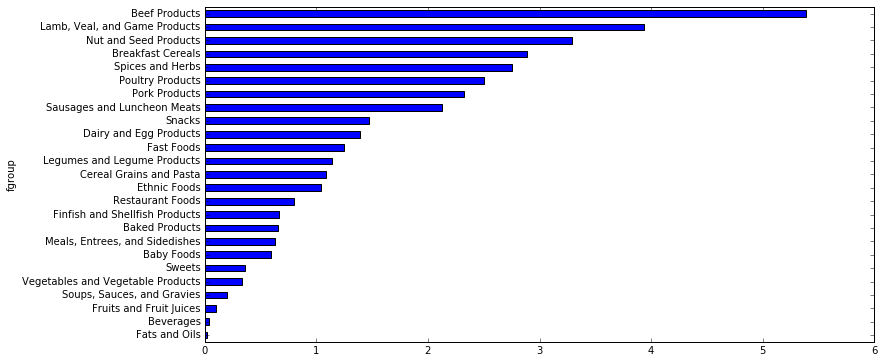

In [220]:
result['Zinc, Zn'].order().plot(kind='barh', figsize = (12, 6))

With a little cleverness, you can find which food is most dense in each nutrient:

In [221]:
by_nutrient = ndata.groupby(['nutgroup', 'nutrient'])

In [222]:
get_maximum = lambda x: x.xs(x.value.idxmax())
get_minimum = lambda x: x.xs(x.value.idxmin())

In [223]:
max_foods = by_nutrient.apply(get_maximum)[['value', 'food']]

In [224]:
# make the food a little smaller
max_foods.food = max_foods.food.str[:50]

The resulting DataFrame is a bit too large to display in the book; here is just the 'Amino
Acids' nutrient group:

In [225]:
max_foods.ix['Amino Acids']['food']

nutrient
Alanine                           Gelatins, dry powder, unsweetened
Arginine                               Seeds, sesame flour, low-fat
Aspartic acid                                   Soy protein isolate
Cystine                Seeds, cottonseed flour, low fat (glandless)
Glutamic acid                                   Soy protein isolate
Glycine                           Gelatins, dry powder, unsweetened
Histidine                Whale, beluga, meat, dried (Alaska Native)
Hydroxyproline    KENTUCKY FRIED CHICKEN, Fried Chicken, ORIGINA...
Isoleucine        Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Leucine           Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Lysine            Seal, bearded (Oogruk), meat, dried (Alaska Na...
Methionine                    Fish, cod, Atlantic, dried and salted
Phenylalanine     Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Proline                           Gelatins, dry powder, unsweetened
Serine            Soy protein isolate, 